# 학습 결과 분석 (EfficientNet / ResNet50 / ViT)

이 노트북은 아래 학습 스크립트들이 저장하는 **로그(txt)**, **분류 리포트(json)**, **혼동행렬(npy)**, **예측/확률(npy)** 파일을 읽어
- 학습 곡선(손실/정확도/F1)
- 모델별 Best epoch 요약
- 클래스별 성능(precision/recall/F1)
- Confusion matrix 시각화  
를 자동으로 생성합니다.

> ⚠️ 실행 전: 학습 스크립트를 실행한 **동일 폴더(또는 그 하위 경로)** 에 결과 파일들이 존재해야 합니다.


In [1]:
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import matplotlib as mpl
from matplotlib import font_manager

import matplotlib as mpl
from matplotlib import font_manager

import shutil
from pathlib import Path

shutil.rmtree(Path.home()/".cache"/"matplotlib", ignore_errors=True)
print("matplotlib cache cleared")


# 설치한 폰트 중 하나로 고정
mpl.rcParams["font.family"] = "NanumGothic"   # 또는 "Noto Sans CJK KR"
mpl.rcParams["axes.unicode_minus"] = False

# (선택) 적용 확인
print("Using:", mpl.rcParams["font.family"])


# ---------------------------------------
# 설정: 결과 파일이 있는 루트 디렉토리
# - 현재 프로젝트 구조 예시: ./log/result/efficientnet/...
# - 해당 폴더가 있으면 자동으로 BASE_DIR을 그쪽으로 맞춥니다.
# ---------------------------------------
CANDIDATES = [
    Path("log/result").resolve(),
    Path("log").resolve(),
    Path(".").resolve(),
]

BASE_DIR = None
for c in CANDIDATES:
    if c.exists():
        BASE_DIR = c
        break
if BASE_DIR is None:
    BASE_DIR = Path(".").resolve()

def find_one(patterns, base=BASE_DIR):
    """여러 glob 패턴 중 처음 발견되는 파일 1개 반환"""
    for pat in patterns:
        hits = list(base.rglob(pat))
        if hits:
            return hits[0]
    return None

def find_all(patterns, base=BASE_DIR):
    """여러 glob 패턴으로 모든 파일 반환"""
    out = []
    for pat in patterns:
        out.extend(list(base.rglob(pat)))
    uniq, seen = [], set()
    for p in out:
        rp = str(p.resolve())
        if rp not in seen:
            seen.add(rp)
            uniq.append(p)
    return uniq
def decode_hash_unicode(s):
    # "#Ubb34#Uc9c8" -> "무질" 같은 형태로 복원
    if not isinstance(s, str):
        return s
    if "#U" not in s:
        return s
    return s.replace("#U", "\\u").encode("utf-8").decode("unicode_escape")


print('BASE_DIR =', BASE_DIR)


matplotlib cache cleared
Using: ['NanumGothic']
BASE_DIR = /nas/home/jj275/DM/date-with-Beak/log/result


## 1) 학습 로그 로드 & 학습 곡선 그리기

- EfficientNet: `./log/efficientnet_training_log.txt` 형태로 저장 (탭 구분, Train/Test Loss/Acc/F1 포함)
- ResNet: `resnet_training_log.txt`
- ViT: `vit_training_log.txt`  
  - 주의: ViT 스크립트는 로그 라인에 `Test F1`을 쓰지 않는 버그가 있어(헤더는 있는데 값이 없음) `NaN` 처리합니다.


In [2]:
import re

import pandas as pd
from pathlib import Path

def load_log_txt(path: Path) -> pd.DataFrame:
    # 너 로그는 탭 구분이라 이게 정답
    df = pd.read_csv(path, sep="\t", engine="python")
    # 숫자 변환
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # 이미 컬럼이 정상이라 그대로 반환
    return df


logs = {
    "efficientnet": find_one(["log/efficientnet_training_log.txt", "**/efficientnet_training_log.txt"]),
    "resnet": find_one(["resnet_training_log.txt", "**/resnet_training_log.txt"]),
    "vit": find_one(["vit_training_log.txt", "**/vit_training_log.txt"]),
}
logs


{'efficientnet': PosixPath('/nas/home/jj275/DM/date-with-Beak/log/result/efficientnet/efficientnet_training_log.txt'),
 'resnet': PosixPath('/nas/home/jj275/DM/date-with-Beak/log/result/resnet/resnet_training_log.txt'),
 'vit': PosixPath('/nas/home/jj275/DM/date-with-Beak/log/result/vit/vit_training_log.txt')}

In [3]:
log_dfs = {}
for name, p in logs.items():
    if p is None:
        print(f"[WARN] {name}: log not found")
        continue
    df = normalize_columns(load_log_txt(p))
    log_dfs[name] = df
    print(f"{name}: {p}  (shape={df.shape})")
    display(df.head())


efficientnet: /nas/home/jj275/DM/date-with-Beak/log/result/efficientnet/efficientnet_training_log.txt  (shape=(30, 6))


Epoch  Train Loss  Train Acc  Test Loss  Test Acc  Test F1
0      1      2.4949     0.2487     2.1582    0.2913   0.2847
1      2      1.7594     0.3777     1.5230    0.4405   0.4334
2      3      1.4246     0.4675     1.4118    0.4671   0.4615
3      4      1.2894     0.5112     1.3570    0.4780   0.4719
4      5      1.1983     0.5396     1.3125    0.4993   0.4893

resnet: /nas/home/jj275/DM/date-with-Beak/log/result/resnet/resnet_training_log.txt  (shape=(30, 6))


Epoch  Train Loss  Train Acc  Test Loss  Test Acc  Test F1
0      1      2.0706     0.2833     1.9126    0.3212   0.2905
1      2      1.6342     0.4034     1.4947    0.4446   0.4251
2      3      1.4540     0.4576     1.3935    0.4765   0.4555
3      4      1.3636     0.4873     1.3432    0.4867   0.4665
4      5      1.2974     0.5082     1.3071    0.4974   0.4802

vit: /nas/home/jj275/DM/date-with-Beak/log/result/vit/vit_training_log.txt  (shape=(30, 6))


Epoch  Train Loss  Train Acc  Test Loss  Test Acc  Test F1
0      1      2.0585     0.2624     1.8546    0.3482   0.3342
1      2      1.5361     0.4290     1.3924    0.4687   0.4581
2      3      1.3324     0.4975     1.3144    0.4931   0.4769
3      4      1.2333     0.5263     1.2760    0.5026   0.4896
4      5      1.1515     0.5541     1.2342    0.5073   0.4990

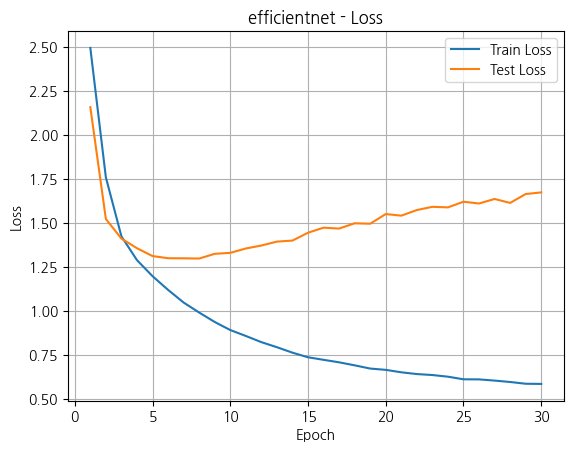

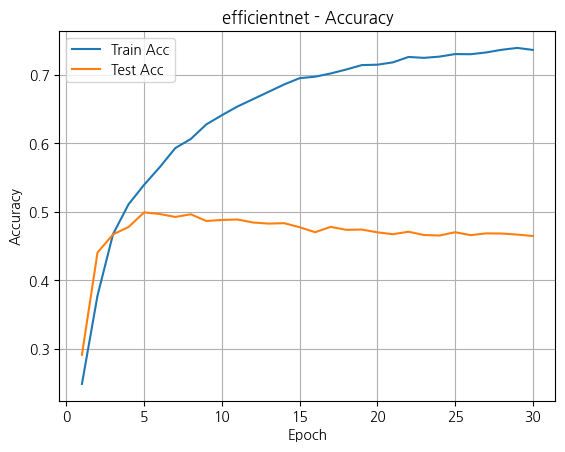

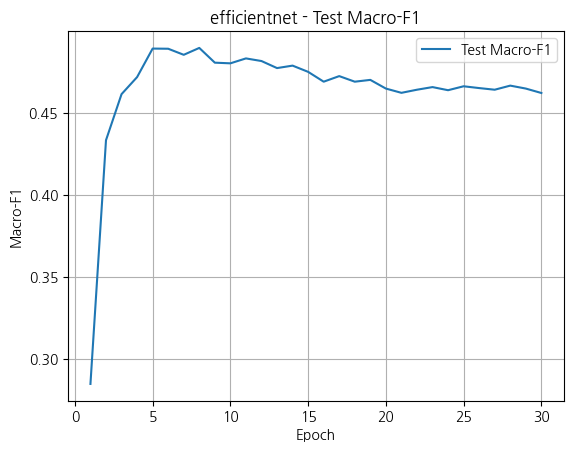

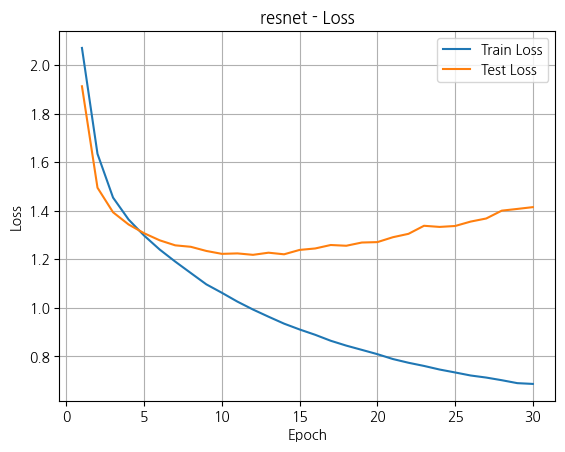

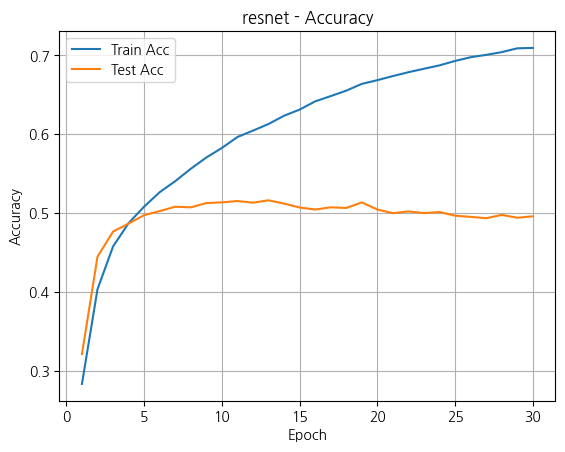

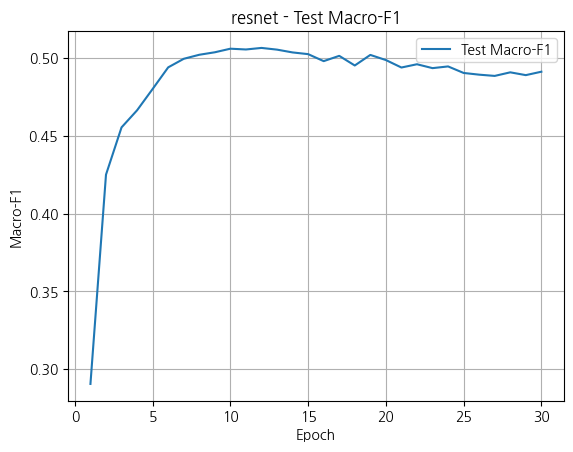

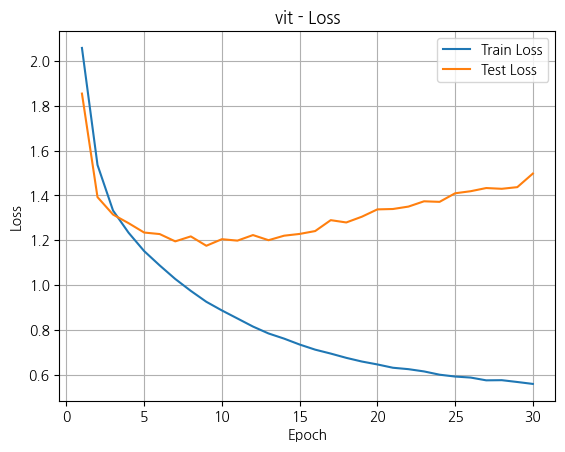

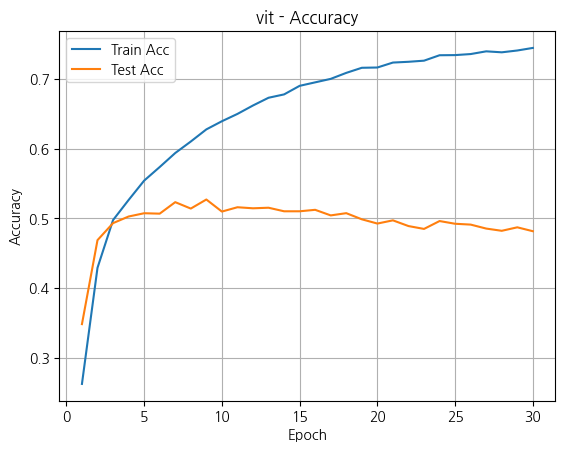

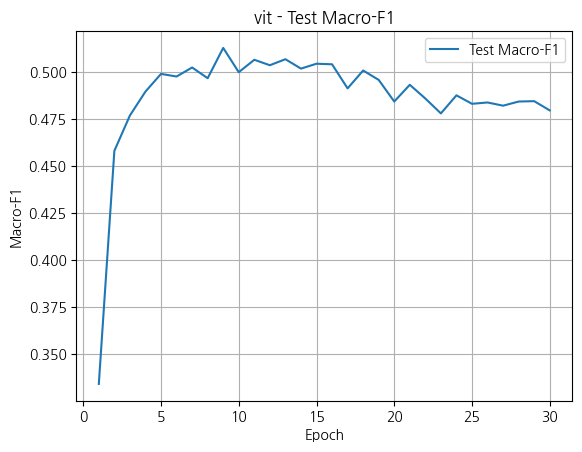

In [4]:
def plot_metrics(df: pd.DataFrame, model_name: str):
    epoch = df["Epoch"] if "Epoch" in df.columns else np.arange(1, len(df)+1)

    if "Train Loss" in df.columns and "Test Loss" in df.columns:
        plt.figure()
        plt.plot(epoch, df["Train Loss"], label="Train Loss")
        plt.plot(epoch, df["Test Loss"], label="Test Loss")
        plt.title(f"{model_name} - Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.legend(); plt.grid(True)
        plt.show()

    if "Train Acc" in df.columns and "Test Acc" in df.columns:
        plt.figure()
        plt.plot(epoch, df["Train Acc"], label="Train Acc")
        plt.plot(epoch, df["Test Acc"], label="Test Acc")
        plt.title(f"{model_name} - Accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.legend(); plt.grid(True)
        plt.show()

    if "Test F1" in df.columns and df["Test F1"].notna().any():
        plt.figure()
        plt.plot(epoch, df["Test F1"], label="Test Macro-F1")
        plt.title(f"{model_name} - Test Macro-F1")
        plt.xlabel("Epoch"); plt.ylabel("Macro-F1")
        plt.legend(); plt.grid(True)
        plt.show()

for name, df in log_dfs.items():
    plot_metrics(df, name)


## 2) Best epoch 요약 (Test Acc 기준)

In [5]:
def summarize_best(df: pd.DataFrame) -> dict:
    if "Test Acc" not in df.columns:
        return {}
    best_idx = df["Test Acc"].astype(float).idxmax()
    out = {
        "best_epoch": int(df.loc[best_idx, "Epoch"]) if "Epoch" in df.columns else int(best_idx+1),
        "best_test_acc": float(df.loc[best_idx, "Test Acc"]),
    }
    for k in ["Test Loss", "Test F1", "Train Loss", "Train Acc"]:
        if k in df.columns:
            v = df.loc[best_idx, k]
            out[k.lower().replace(" ", "_")] = float(v) if pd.notna(v) else np.nan
    return out

summary = []
for name, df in log_dfs.items():
    s = summarize_best(df)
    if s:
        s["model"] = name
        summary.append(s)

summary_df = pd.DataFrame(summary).set_index("model").sort_values("best_test_acc", ascending=False)
summary_df


best_epoch  best_test_acc  test_loss  test_f1  train_loss  \
model                                                                     
vit                    9         0.5270     1.1752   0.5128      0.9250   
resnet                13         0.5162     1.2270   0.5055      0.9633   
efficientnet           5         0.4993     1.3125   0.4893      1.1983   

              train_acc  
model                    
vit              0.6276  
resnet           0.6130  
efficientnet     0.5396

## 3) 최종 저장된 예측/확률로 메트릭 재계산 (선택)

학습 스크립트가 저장한 `*_test_predictions.npy`, `*_test_labels.npy`, `*_test_probs.npy` 를 이용합니다.


In [6]:
from sklearn.metrics import accuracy_score, f1_score

def load_preds(prefix: str):
    pred = find_one([f"{prefix}_test_predictions.npy", f"**/{prefix}_test_predictions.npy"])
    lab  = find_one([f"{prefix}_test_labels.npy",       f"**/{prefix}_test_labels.npy"])
    prob = find_one([f"{prefix}_test_probs.npy",        f"**/{prefix}_test_probs.npy"])
    if pred is None or lab is None:
        return None
    y_pred = np.load(pred)
    y_true = np.load(lab)
    y_prob = np.load(prob) if prob is not None else None
    return y_true, y_pred, y_prob, pred, lab, prob

prefix_map = {"efficientnet": "efficientnet", "resnet": "resnet", "vit": "vit"}

recalc_rows = []
for model, prefix in prefix_map.items():
    pack = load_preds(prefix)
    if pack is None:
        print(f"[WARN] {model}: prediction files not found")
        continue
    y_true, y_pred, y_prob, pred_p, lab_p, prob_p = pack
    recalc_rows.append({
        "model": model,
        "acc": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "pred_path": str(pred_p),
        "label_path": str(lab_p),
        "prob_path": str(prob_p) if prob_p is not None else None,
    })

pd.DataFrame(recalc_rows).set_index("model")


acc  macro_f1  \
model                              
efficientnet  0.464818  0.462231   
resnet        0.495909  0.491305   
vit           0.481455  0.479555   

                                                      pred_path  \
model                                                             
efficientnet  /nas/home/jj275/DM/date-with-Beak/log/result/e...   
resnet        /nas/home/jj275/DM/date-with-Beak/log/result/r...   
vit           /nas/home/jj275/DM/date-with-Beak/log/result/v...   

                                                     label_path  \
model                                                             
efficientnet  /nas/home/jj275/DM/date-with-Beak/log/result/e...   
resnet        /nas/home/jj275/DM/date-with-Beak/log/result/r...   
vit           /nas/home/jj275/DM/date-with-Beak/log/result/v...   

                                                      prob_path  
model                                                            
efficientnet  /nas/home/jj275/DM/date-with-Beak/log/result/e...  
resnet        /nas/home/jj275/DM/date-with-Beak/log/result/r...  
vit           /nas/home/jj275/DM/date-with-Beak/log/result/v...

## 4) Classification report(json) 분석

In [7]:
def load_report(prefix: str):
    p = find_one([f"{prefix}_classification_report.json", f"**/{prefix}_classification_report.json"])
    if p is None:
        return None, None
    rep = json.loads(p.read_text(encoding="utf-8", errors="ignore"))
    return rep, p

def report_to_df(rep: dict):
    rows = []
    for k, v in rep.items():
        if isinstance(v, dict):
            row = {"label": decode_hash_unicode(k)}  # ✅ 여기서 바로 디코딩
            row.update(v)
            rows.append(row)
    return pd.DataFrame(rows)


for model, prefix in prefix_map.items():
    rep, p = load_report(prefix)
    if rep is None:
        print(f"[WARN] {model}: report not found")
        continue
    df = report_to_df(rep)
    print(model, "->", p)
    display(df.sort_values("f1-score", ascending=False).head(12))


efficientnet -> /nas/home/jj275/DM/date-with-Beak/log/result/efficientnet/efficientnet_classification_report.json


label  precision    recall  f1-score  support
2            무질환   0.946502  0.920000  0.933063   1000.0
1        궤양성각막질환   0.669540  0.699000  0.683953   1000.0
8           안검종양   0.661448  0.676000  0.668645   1000.0
3            백내장   0.522330  0.538000  0.530049   1000.0
12  weighted avg   0.461003  0.464818  0.462231  11000.0
11     macro avg   0.461003  0.464818  0.462231  11000.0
6          안검내반증   0.440400  0.484000  0.461172   1000.0
9            유루증   0.432638  0.456000  0.444012   1000.0
5       색소침착성각막염   0.401932  0.416000  0.408845   1000.0
10           핵경화   0.381274  0.395000  0.388016   1000.0
4       비궤양성각막질환   0.347882  0.271000  0.304666   1000.0
7            안검염   0.136364  0.141000  0.138643   1000.0

resnet -> /nas/home/jj275/DM/date-with-Beak/log/result/resnet/resnet_classification_report.json


label  precision    recall  f1-score  support
2            무질환   0.912959  0.944000  0.928220   1000.0
8           안검종양   0.639371  0.773000  0.699864   1000.0
1        궤양성각막질환   0.716289  0.664000  0.689154   1000.0
3            백내장   0.541806  0.486000  0.512388   1000.0
12  weighted avg   0.488900  0.495909  0.491305  11000.0
11     macro avg   0.488900  0.495909  0.491305  11000.0
9            유루증   0.461101  0.486000  0.473223   1000.0
6          안검내반증   0.448880  0.461000  0.454859   1000.0
5       색소침착성각막염   0.418561  0.442000  0.429961   1000.0
10           핵경화   0.395215  0.413000  0.403912   1000.0
4       비궤양성각막질환   0.370040  0.373000  0.371514   1000.0
0            결막염   0.254276  0.223000  0.237613   1000.0

vit -> /nas/home/jj275/DM/date-with-Beak/log/result/vit/vit_classification_report.json


label  precision    recall  f1-score  support
2            무질환   0.923828  0.946000  0.934783   1000.0
8           안검종양   0.619504  0.775000  0.688583   1000.0
1        궤양성각막질환   0.696409  0.640000  0.667014   1000.0
3            백내장   0.522449  0.512000  0.517172   1000.0
11     macro avg   0.480824  0.481455  0.479555  11000.0
12  weighted avg   0.480824  0.481455  0.479555  11000.0
6          안검내반증   0.501718  0.438000  0.467699   1000.0
9            유루증   0.506039  0.419000  0.458425   1000.0
5       색소침착성각막염   0.413953  0.445000  0.428916   1000.0
10           핵경화   0.397727  0.420000  0.408560   1000.0
4       비궤양성각막질환   0.348910  0.336000  0.342333   1000.0
0            결막염   0.192198  0.202000  0.196977   1000.0

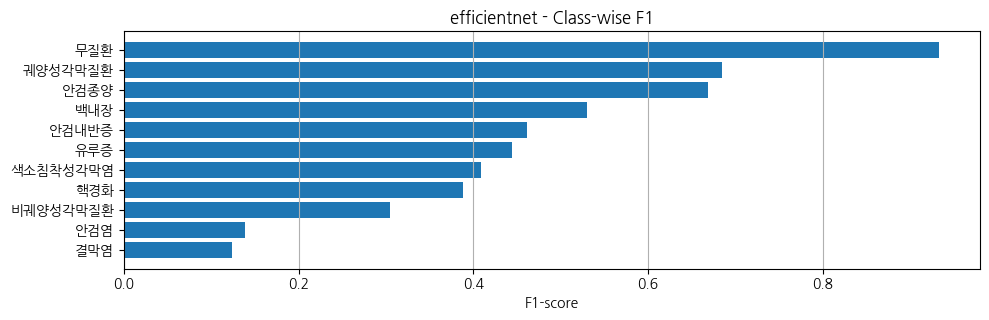

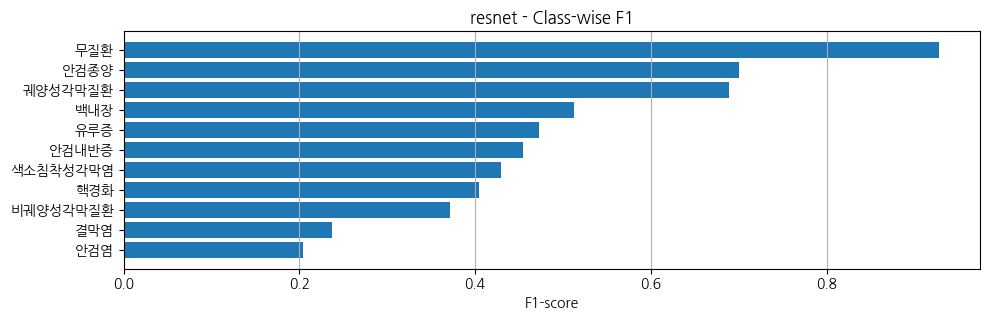

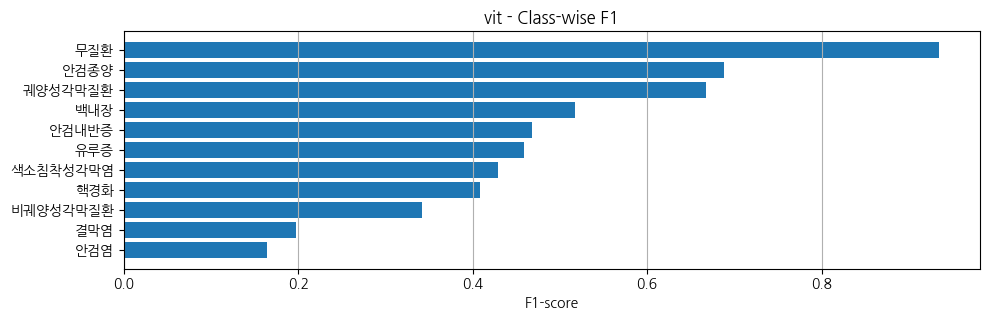

In [8]:
def plot_class_f1(rep: dict, title: str):
    df = report_to_df(rep)
    df_cls = df[~df["label"].str.contains("avg", na=False)].copy()
    df_cls = df_cls.sort_values("f1-score", ascending=False)

    plt.figure(figsize=(10, max(3, 0.3*len(df_cls))))
    plt.barh(df_cls["label"], df_cls["f1-score"])
    plt.gca().invert_yaxis()
    plt.title(f"{title} - Class-wise F1")
    plt.xlabel("F1-score")
    plt.grid(True, axis="x")
    plt.tight_layout()
    plt.show()

for model, prefix in prefix_map.items():
    rep, _ = load_report(prefix)
    if rep is None:
        continue
    plot_class_f1(rep, model)


## 5) Confusion matrix(npy) 시각화

efficientnet -> /nas/home/jj275/DM/date-with-Beak/log/result/efficientnet/efficientnet_confusion_matrix.npy shape: (11, 11)


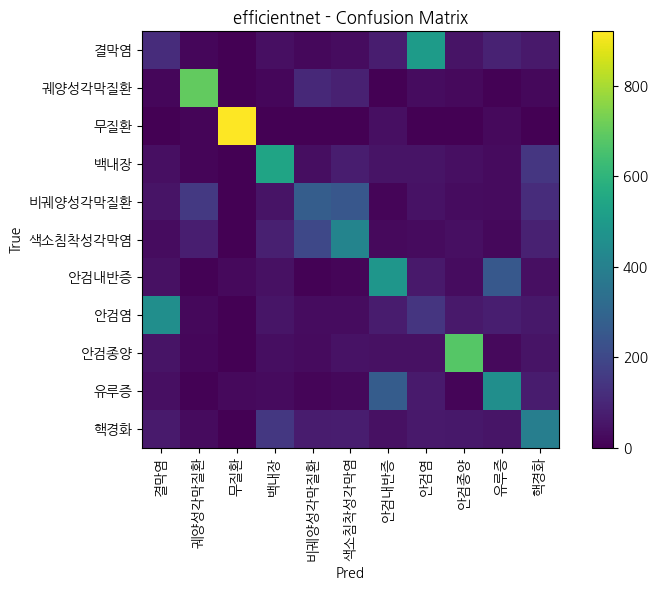

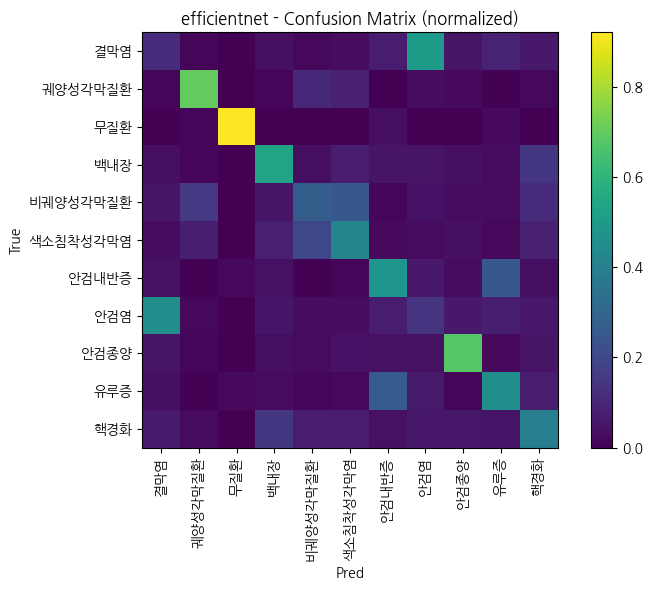

resnet -> /nas/home/jj275/DM/date-with-Beak/log/result/resnet/resnet_confusion_matrix.npy shape: (11, 11)


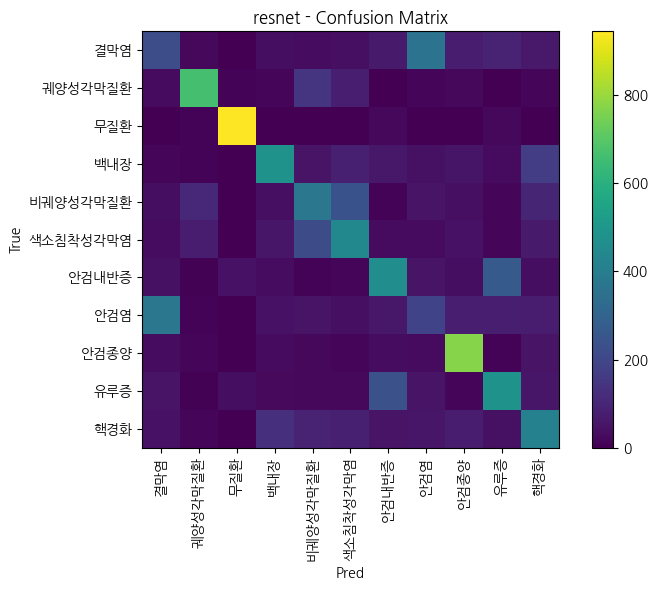

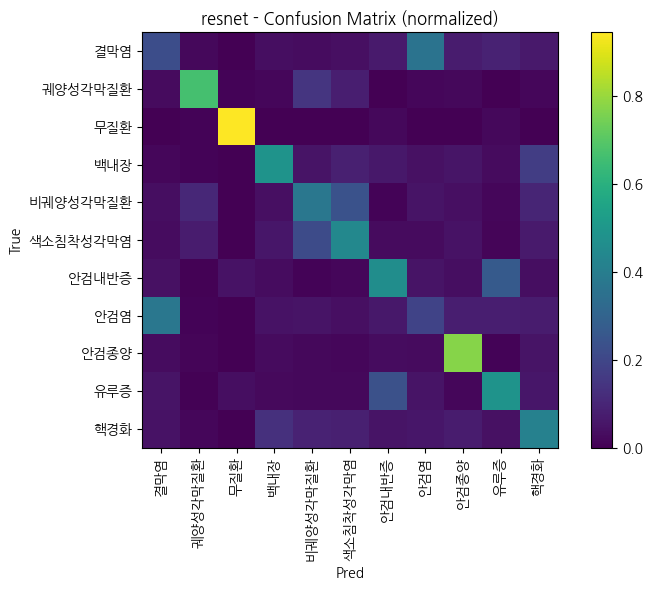

vit -> /nas/home/jj275/DM/date-with-Beak/log/result/vit/vit_confusion_matrix.npy shape: (11, 11)


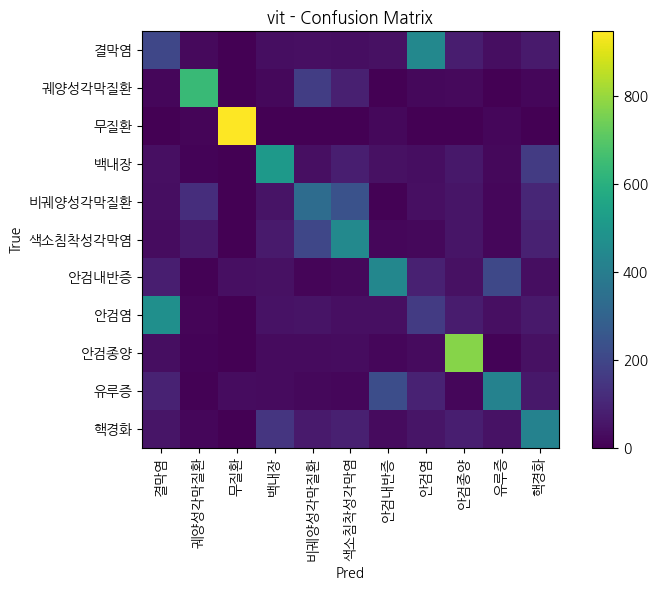

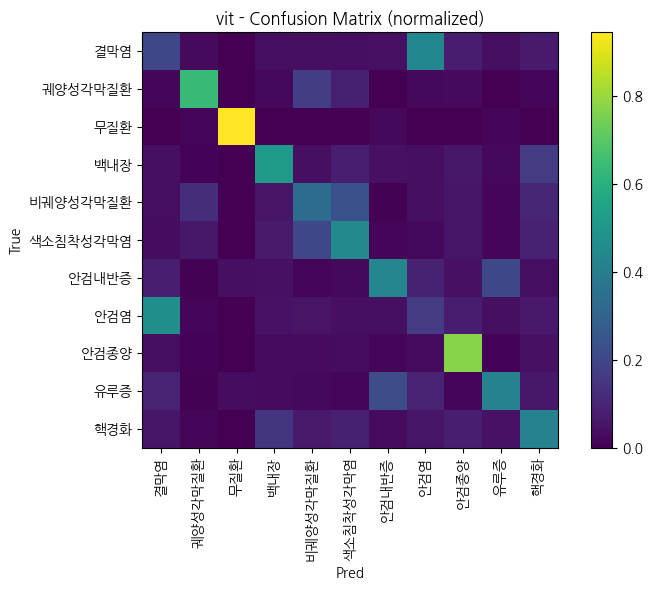

In [9]:
def load_cm(prefix: str):
    p = find_one([f"{prefix}_confusion_matrix.npy", f"**/{prefix}_confusion_matrix.npy"])
    if p is None:
        return None, None
    cm = np.load(p)
    return cm, p

def plot_cm(cm: np.ndarray, title: str, class_names=None, normalize=False):
    if normalize:
        cm_disp = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
    else:
        cm_disp = cm

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_disp, interpolation="nearest")
    plt.title(title + (" (normalized)" if normalize else ""))
    plt.colorbar()
    if class_names is not None and len(class_names) == cm.shape[0]:
        plt.xticks(range(len(class_names)), class_names, rotation=90)
        plt.yticks(range(len(class_names)), class_names)
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()
    plt.show()

for model, prefix in prefix_map.items():
    cm, p = load_cm(prefix)
    if cm is None:
        print(f"[WARN] {model}: CM not found")
        continue

    rep, _ = load_report(prefix)
    class_names = None
    if rep is not None:
        df = report_to_df(rep)
        cls = df[~df["label"].str.contains("avg", na=False)]["label"].tolist()
        if len(cls) == cm.shape[0]:
            class_names = cls

    print(model, "->", p, "shape:", cm.shape)
    plot_cm(cm, f"{model} - Confusion Matrix", class_names=class_names, normalize=False)
    plot_cm(cm, f"{model} - Confusion Matrix", class_names=class_names, normalize=True)


## 6) (옵션) 데이터 폴더가 있을 때, 오분류 샘플 몇 개 보기

이 셀은 **test set 폴더가 실제로 존재할 때만** 실행하세요.

- EfficientNet/ResNet 스크립트는 `./data/test` 형태를 사용합니다. fileciteturn1file0L10-L15 fileciteturn1file1L13-L18  
- ViT 스크립트는 `./test` 를 사용합니다. fileciteturn1file2L13-L18


Dataset size: 11000 classes: ['#Uacb0#Ub9c9#Uc5fc', '#Uada4#Uc591#Uc131#Uac01#Ub9c9#Uc9c8#Ud658', '#Ubb34#Uc9c8#Ud658', '#Ubc31#Ub0b4#Uc7a5', '#Ube44#Uada4#Uc591#Uc131#Uac01#Ub9c9#Uc9c8#Ud658', '#Uc0c9#Uc18c#Uce68#Ucc29#Uc131#Uac01#Ub9c9#Uc5fc', '#Uc548#Uac80#Ub0b4#Ubc18#Uc99d', '#Uc548#Uac80#Uc5fc', '#Uc548#Uac80#Uc885#Uc591', '#Uc720#Ub8e8#Uc99d', '#Ud575#Uacbd#Ud654']


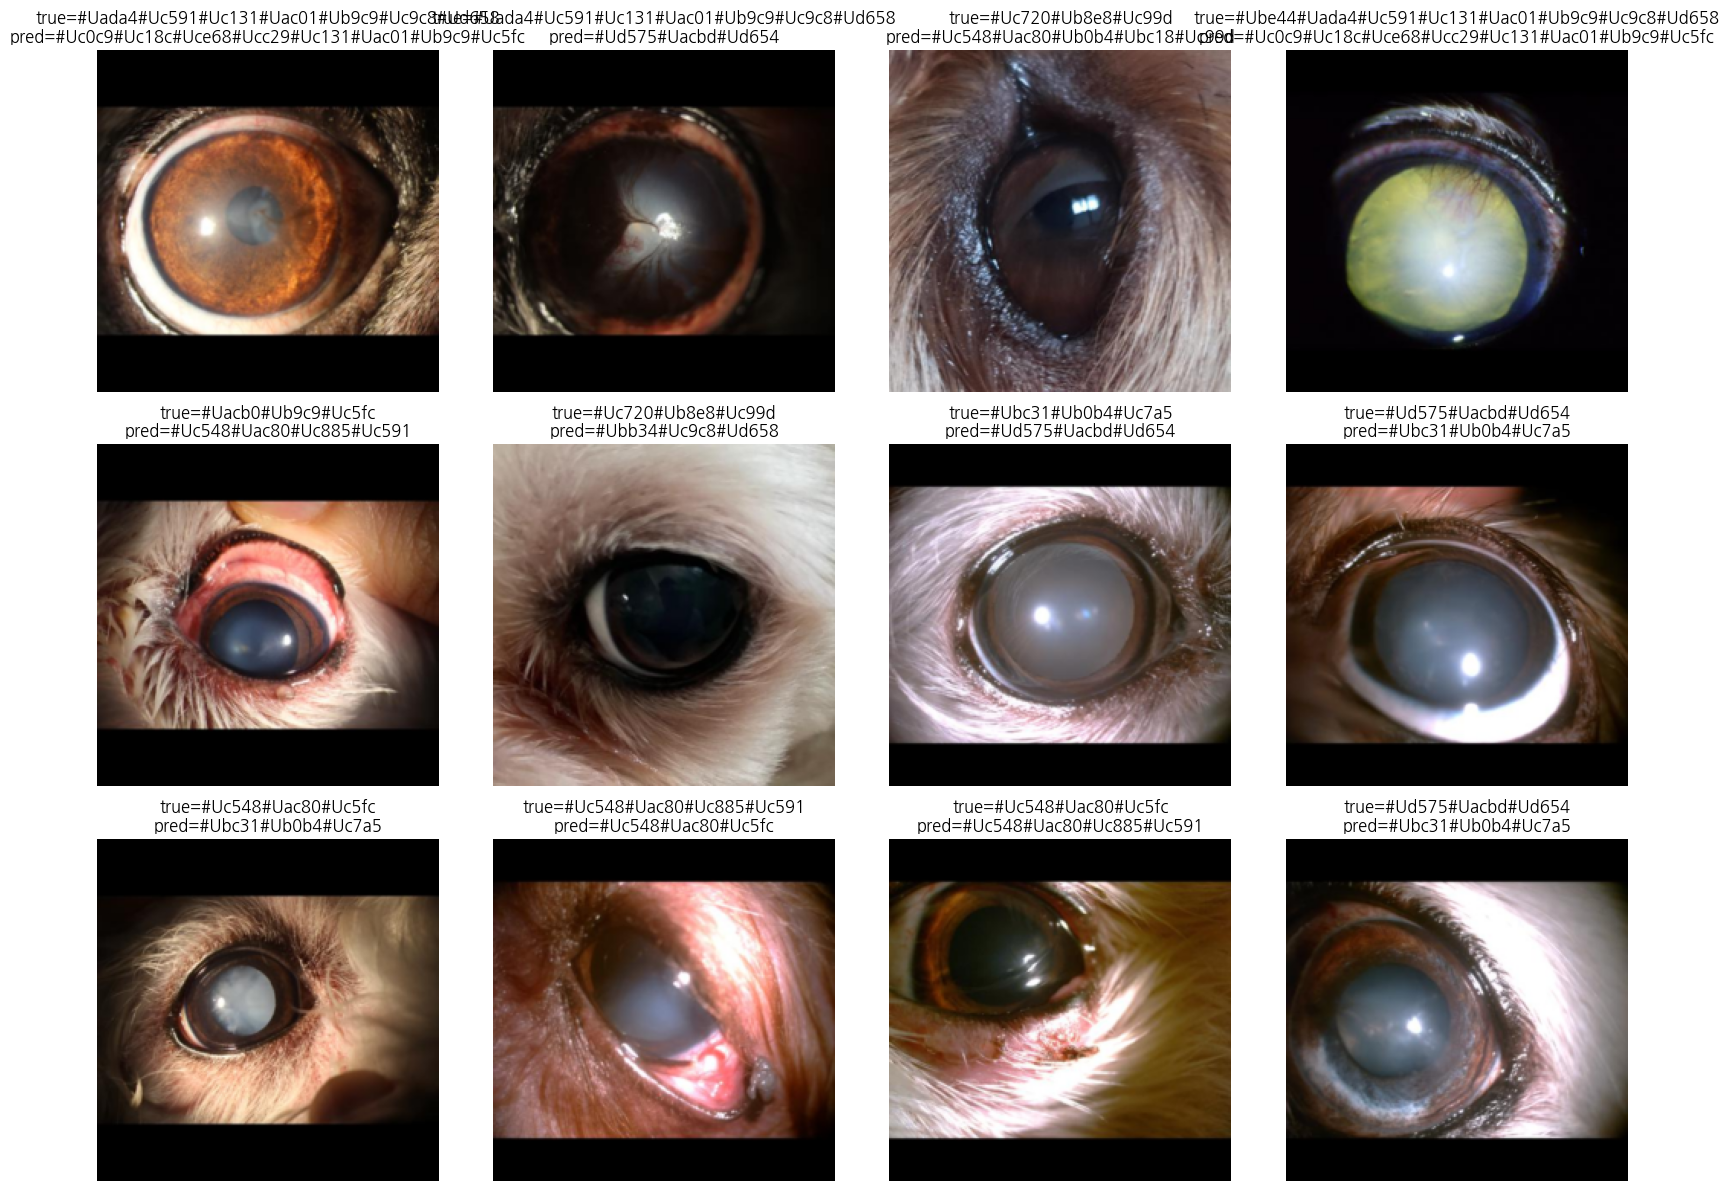

Dataset size: 11000 classes: ['#Uacb0#Ub9c9#Uc5fc', '#Uada4#Uc591#Uc131#Uac01#Ub9c9#Uc9c8#Ud658', '#Ubb34#Uc9c8#Ud658', '#Ubc31#Ub0b4#Uc7a5', '#Ube44#Uada4#Uc591#Uc131#Uac01#Ub9c9#Uc9c8#Ud658', '#Uc0c9#Uc18c#Uce68#Ucc29#Uc131#Uac01#Ub9c9#Uc5fc', '#Uc548#Uac80#Ub0b4#Ubc18#Uc99d', '#Uc548#Uac80#Uc5fc', '#Uc548#Uac80#Uc885#Uc591', '#Uc720#Ub8e8#Uc99d', '#Ud575#Uacbd#Ud654']


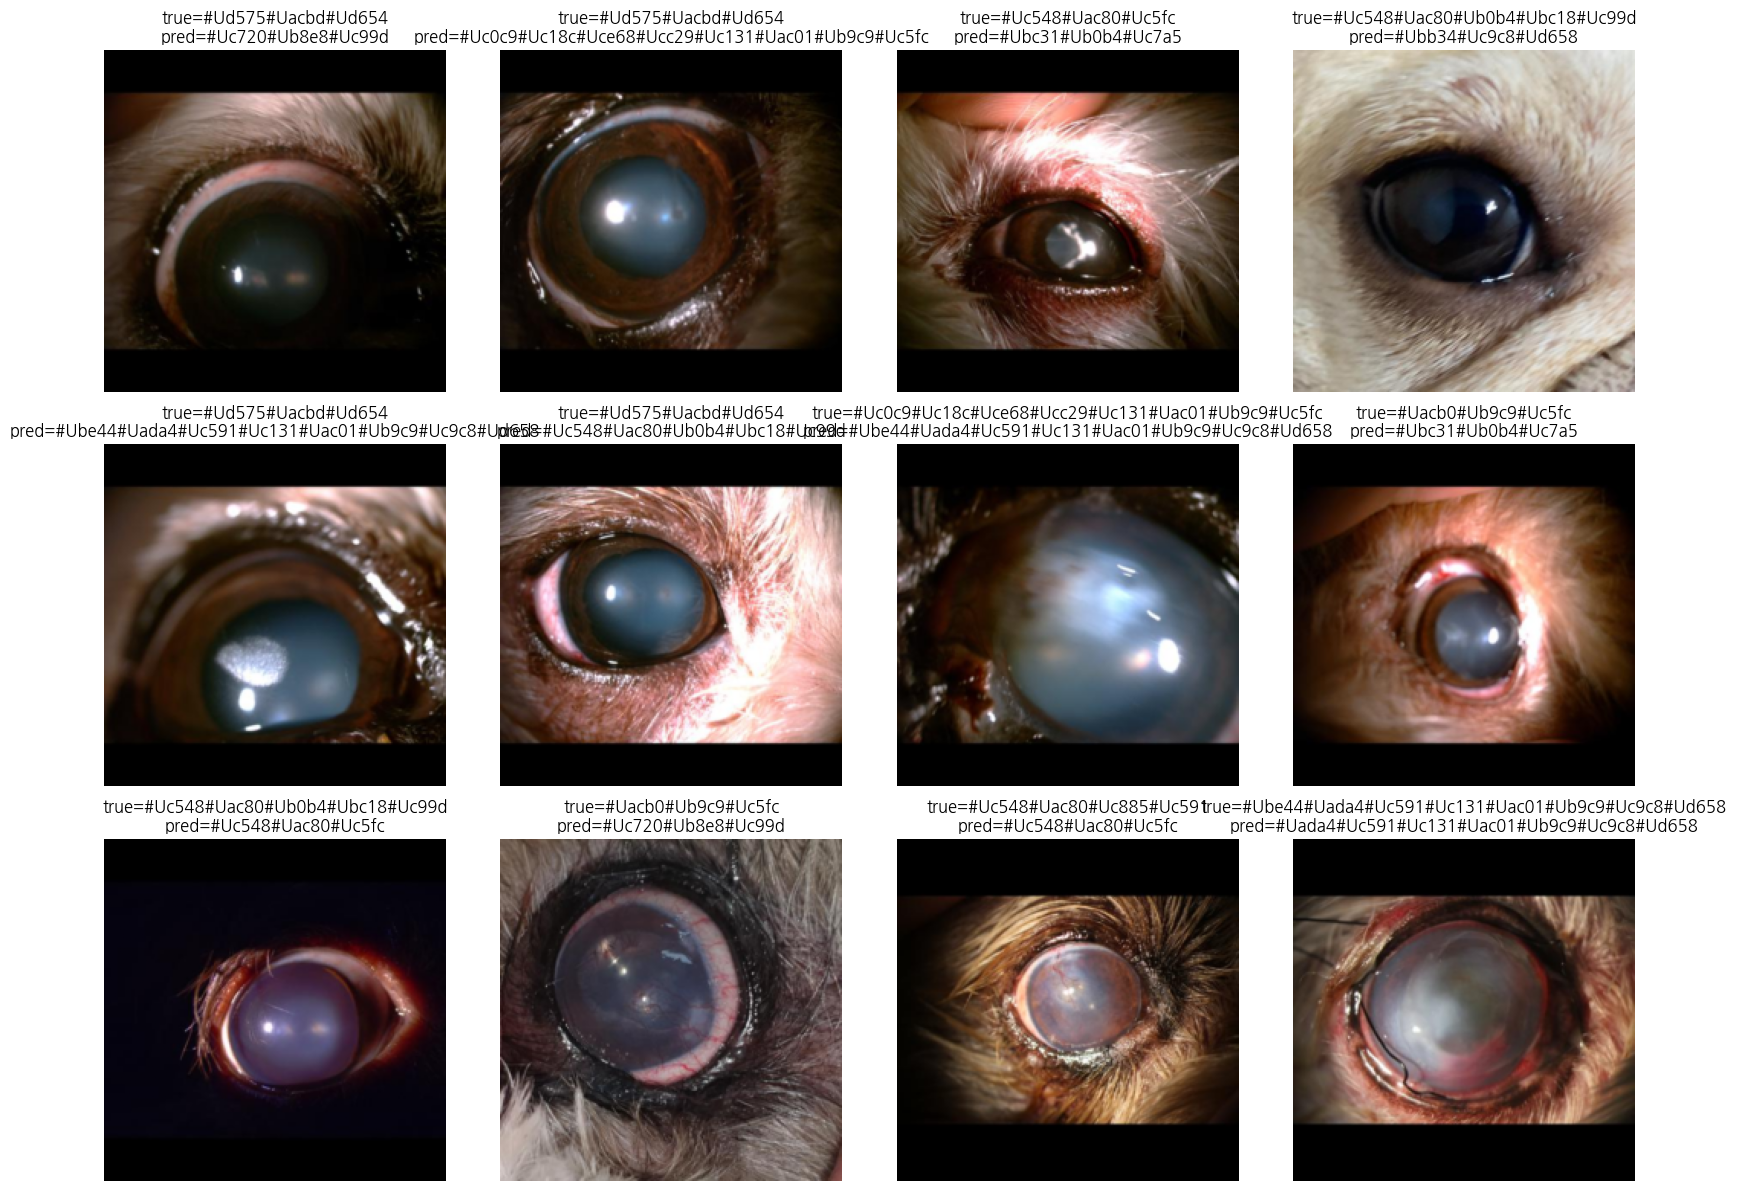

Dataset size: 11000 classes: ['#Uacb0#Ub9c9#Uc5fc', '#Uada4#Uc591#Uc131#Uac01#Ub9c9#Uc9c8#Ud658', '#Ubb34#Uc9c8#Ud658', '#Ubc31#Ub0b4#Uc7a5', '#Ube44#Uada4#Uc591#Uc131#Uac01#Ub9c9#Uc9c8#Ud658', '#Uc0c9#Uc18c#Uce68#Ucc29#Uc131#Uac01#Ub9c9#Uc5fc', '#Uc548#Uac80#Ub0b4#Ubc18#Uc99d', '#Uc548#Uac80#Uc5fc', '#Uc548#Uac80#Uc885#Uc591', '#Uc720#Ub8e8#Uc99d', '#Ud575#Uacbd#Ud654']


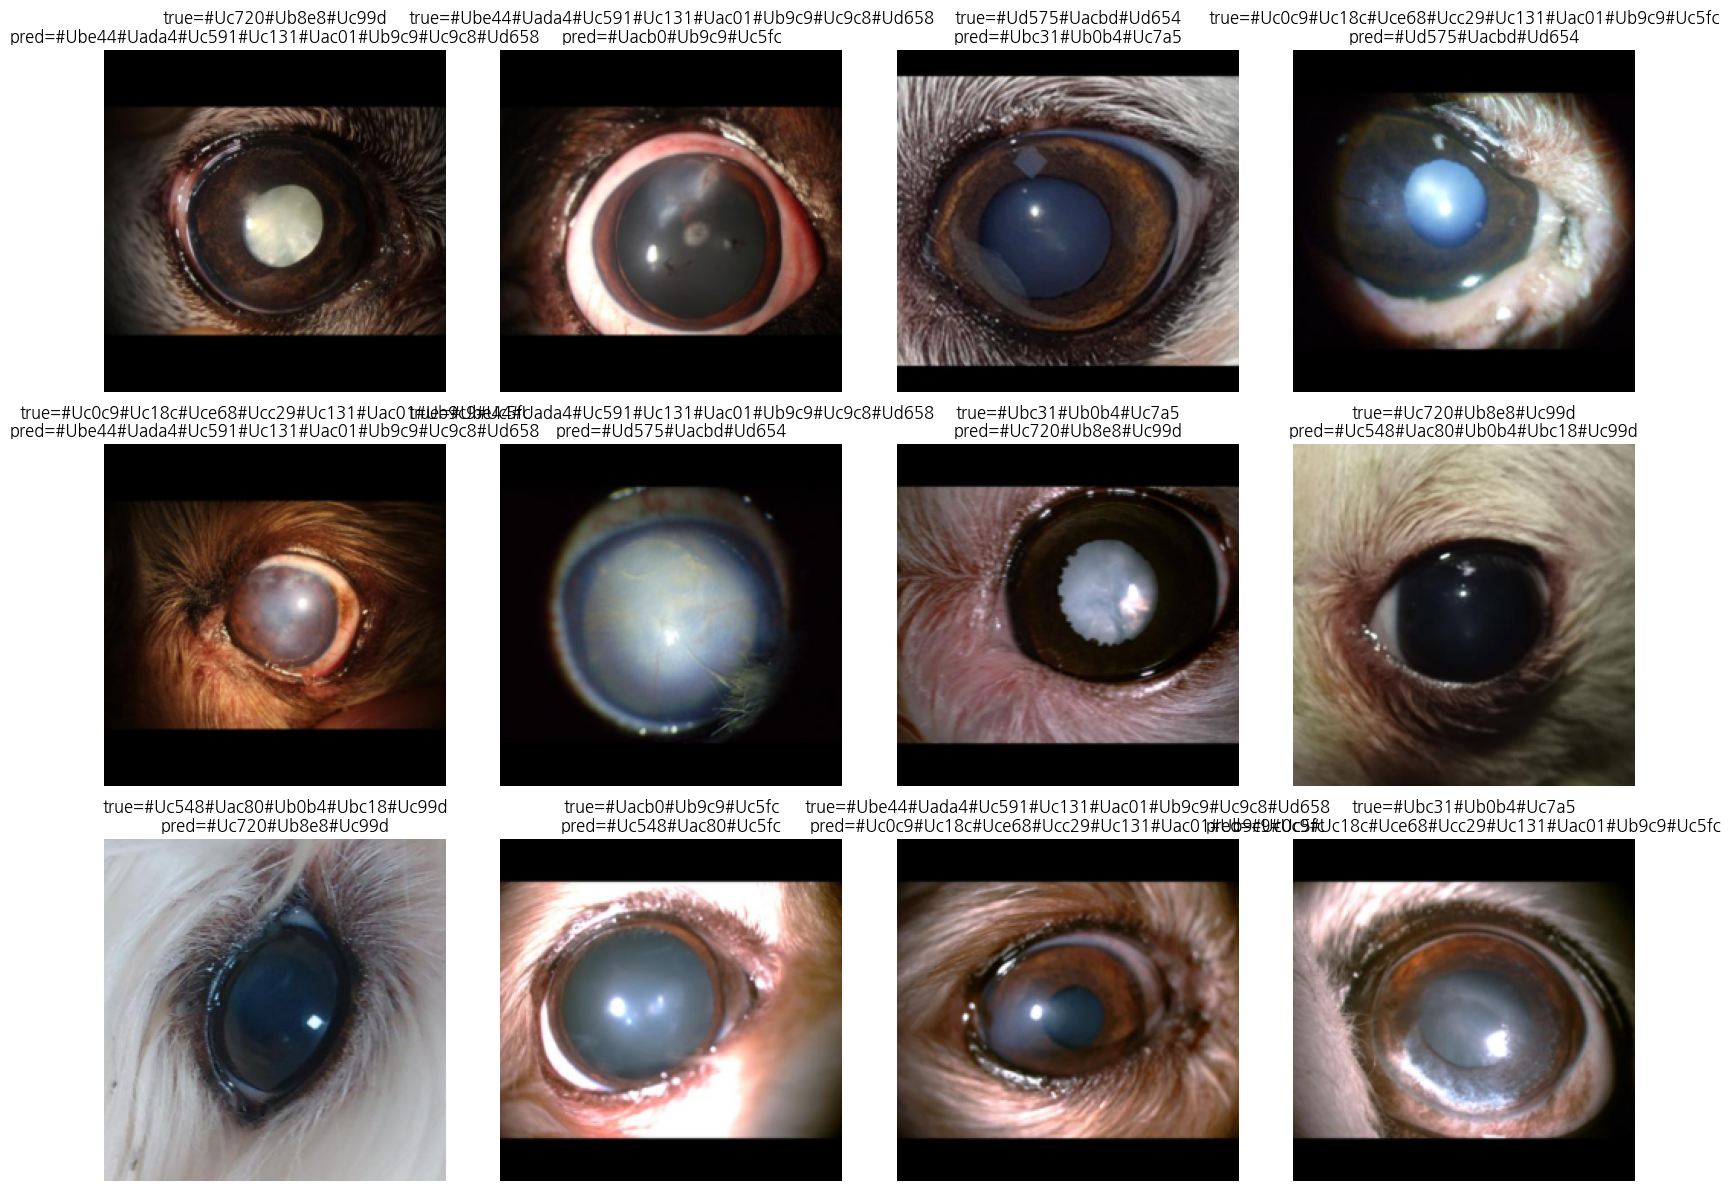

In [14]:
# 선택 실행: 데이터 폴더 존재할 때만
import random

try:
    import torch
    from torchvision import datasets, transforms
except Exception as e:
    print("torch/torchvision import failed:", e)

def show_misclassified_samples(prefix: str, test_dir: Path, n=12):
    pack = load_preds(prefix)
    if pack is None:
        print("prediction files not found for", prefix)
        return
    y_true, y_pred, y_prob, *_ = pack

    if not test_dir.exists():
        print("test_dir not found:", test_dir)
        return

    tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
    ds = datasets.ImageFolder(root=str(test_dir), transform=tfm)
    print("Dataset size:", len(ds), "classes:", ds.classes)

    if len(ds) != len(y_true):
        print("[WARN] dataset size != saved labels size; (", len(ds), "!=", len(y_true), ")")
        print("정확 매칭이 필요하면 평가 시 파일 경로를 함께 저장하는 방식으로 수정하는 것을 권장합니다.")
        return

    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("No misclassifications 🎉")
        return

    sel = np.random.choice(wrong, size=min(n, len(wrong)), replace=False)

    cols = 4
    rows = int(np.ceil(len(sel)/cols))
    plt.figure(figsize=(cols*4, rows*4))
    for i, idx in enumerate(sel, 1):
        x, y = ds[idx]
        plt.subplot(rows, cols, i)
        img = x.permute(1,2,0).numpy()
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"true={ds.classes[y_true[idx]]}\npred={ds.classes[y_pred[idx]]}")
    plt.tight_layout()
    plt.show()

# 예시:
show_misclassified_samples("efficientnet", Path("./data/test"), n=12)
show_misclassified_samples("resnet", Path("./data/test"), n=12)
show_misclassified_samples("vit", Path("./data/test"), n=12)
